# RNA-Seq Analysis Training Demo

## Overview

This tutorial will show you the following workflow that is used to generate the list of differentially expressed genes.


![RNA-Seq workflow](images/count-workflow.png)

### STEP 1: Library Installation

First install the R packages that will be used.

In [1]:
###install the libraries first, if required
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

if (!require("ComplexHeatmap"))
    BiocManager::install("ComplexHeatmap")

if (!require("DESeq2"))
    BiocManager::install("DESeq2")

if (!require("dplyr"))
    install.packages("dplyr")

if (!require("pheatmap"))
    install.packages("pheatmap")

if (!require("ggrepel"))
    install.packages("ggrepel")

###load the libraries
library(DESeq2)
library(dplyr)
library(pheatmap)
library(ComplexHeatmap)
library(ggplot2)
library(ggrepel)

Loading required package: DESeq2

Loading required package: S4Vectors

Warning message:
“package ‘S4Vectors’ was built under R version 4.1.2”
Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Warning message:
“package ‘IRanges’ was built under R vers

### STEP 2: Reading in Data

Next load in the gene count data that will be analyzed.

To make the next steps easier we will also reformat the data a little bit.

First, as the next steps will process the data mathematically, we will create a variable which holds only the columns of data which contain the numerical read count data, removing non-numerical or metadata columns such as the rowname column.

Additionally, as we will use normalization involving logarithms, we will replace all readcount values of '0' in our data, with '1'. This will change the data only slightly, and will prevent these zeroes from causing an 'undefined' or 'N/A' math error in the logarithm normalization step.


In [2]:
#get genecounts and annotation file from cloud storage bucket
system("mkdir -p data/gene_counts", intern=TRUE)
system("mkdir -p data/reference", intern=TRUE)
system("curl https://storage.googleapis.com/me-inbre-rnaseq-pipelinev2/data/salmon/SRP300216_merged_quants.txt --output data/gene_counts/SRP300216_genecounts.txt", intern=TRUE)
system("curl https://storage.googleapis.com/me-inbre-rnaseq-pipelinev2/data/reference/GCF_001632805.1_ASM163280v1_feature_table.txt --output data/reference/GCF_001632805.1_ASM163280v1_feature_table.txt", intern=TRUE)


#assign the raw gene count file to a variable 'read_counts'
read_counts <- read.table('data/gene_counts/SRP300216_genecounts.txt',head=TRUE)

#replace all count entries of '0' in the raw gene count file with '1'.
read_counts[read_counts==0] <- 1

#assign the numerical read counts to another variable we will call 'rnaseqMatrix'
rnaseqMatrix <- round(read_counts[,c(2:13)])


#label the rownames of this matrix with the rowname column from the gene count file.
rownames(rnaseqMatrix) <- read_counts[,1]

head(rnaseqMatrix)


character(0)

character(0)

character(0)

character(0)

,SRR13349122,SRR13349123,SRR13349124,SRR13349125,SRR13349126,SRR13349127,SRR13349128,SRR13349129,SRR13349130,SRR13349131,SRR13349132,SRR13349133
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BB28_RS24845,59,59,40,54,47,58,14,31,21,15,19,27
BB28_RS24840,156,152,138,158,118,170,49,52,41,40,64,73
BB28_RS24300,495,525,396,438,438,493,155,197,128,131,180,225
BB28_RS24270,2,1,3,1,1,1,1,1,1,1,1,2
BB28_RS24265,9,17,5,9,2,15,2,3,2,4,8,1
BB28_RS24255,11,7,11,8,9,6,11,14,10,16,19,31


### STEP 4: Specifying Experimental Design

Next specify the experimental design. The deseq2 tool will use this design to calculate information about differences in gene expression between specified groups.

In [3]:
# define the sample experimental design

samples_treatment <- data.frame(matrix(c(rep("WT",6),rep("BPs_lysogen",6)),ncol=1))
samples_ID <- data.frame(matrix(colnames(rnaseqMatrix),ncol=1))
samples <- cbind(samples_ID,samples_treatment)
names(samples) <- c("ID","Treatment")
rownames(samples) <- samples[,1]

# example of how an experimental design table might look, in this case
# comprised of a column with sample ids, and a column with treatment group id
samples



,ID,Treatment
,<chr>,<chr>
SRR13349122,SRR13349122,WT
SRR13349123,SRR13349123,WT
SRR13349124,SRR13349124,WT
SRR13349125,SRR13349125,WT
SRR13349126,SRR13349126,WT
SRR13349127,SRR13349127,WT
SRR13349128,SRR13349128,BPs_lysogen
SRR13349129,SRR13349129,BPs_lysogen
SRR13349130,SRR13349130,BPs_lysogen


### STEP 5: Creating Deseq2 Object

Now input the treatment design matrix, as well as the readcount data, into the deseq2 tool to create a deseq2 object. This is also an opportunity to inspect pre-normalized data using pairwise comparison plots.

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


[1] 4906   12

[1] 4906   12

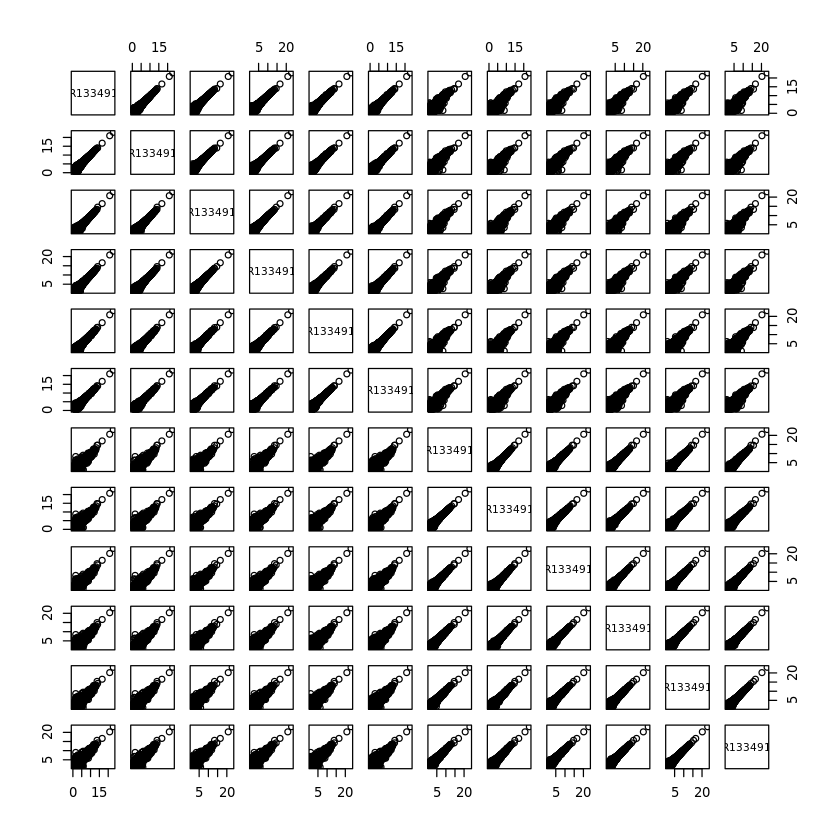

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



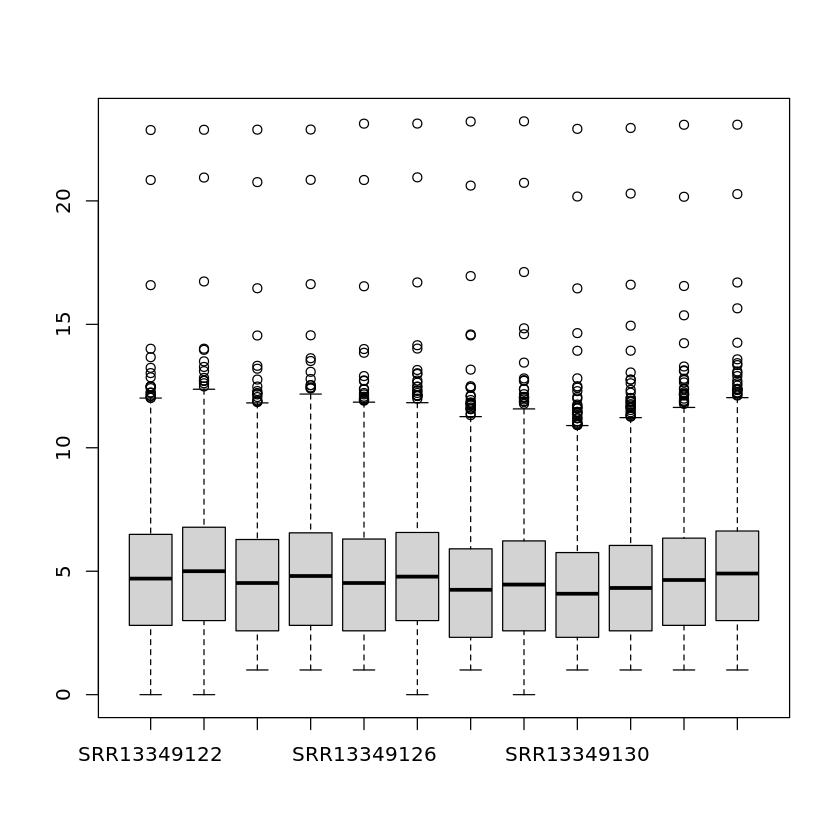

In [4]:
#Create the DEseq2DataSet object
deseq2Data <- DESeqDataSetFromMatrix(countData = rnaseqMatrix,
                              colData = samples,
                              design = ~ Treatment)

# Filter lowly expressed genes
dim(deseq2Data)
dim(deseq2Data[rowSums(counts(deseq2Data)) > 10, ])

# Perform pre-filtering of the data
deseq2Data <- deseq2Data[rowSums(counts(deseq2Data)) > 10, ]

# Inspect pre-normalized data (this can take a long time to run)
#pairs((counts(deseq2Data)))
#hist((counts(deseq2Data)))
#boxplot((counts(deseq2Data)))

pairs(log2((counts(deseq2Data)+1)))
#hist((counts(deseq2Data)))
boxplot(log2((counts(deseq2Data)+1)))

# Run pipeline for differential expression steps
deseq2Data <- DESeq(deseq2Data)


### STEP 6: Normalize Data

Now normalize the data using the 'regular normalization' function from deseq2.

Normalization of gene readcounts across samples will help to minimize sample variation noise and ensure more accurate comparisons.

In [5]:
#perform rlog normalization on deseq2 object
rld <- rlog(deseq2Data, blind=FALSE)
#a variable to easily retrieve matrix of rlog genecount values from deseq object
rlogcounts <- assay(rld)
rownames(rlogcounts) <- rownames(deseq2Data)
#a variable to easily retrieve matrix of rlog genecount values from deseq object
head(rlogcounts)

,SRR13349122,SRR13349123,SRR13349124,SRR13349125,SRR13349126,SRR13349127,SRR13349128,SRR13349129,SRR13349130,SRR13349131,SRR13349132,SRR13349133
BB28_RS24845,5.5173373,5.3203123,5.238671,5.380138,5.3938321,5.4371112,4.6317708,5.0428593,4.9645060,4.6326787,4.6513561,4.7326682
BB28_RS24840,7.0203605,6.7473125,6.996058,6.975100,6.8157966,7.0460728,6.0897440,5.9687928,6.0322325,5.8521914,6.1241707,6.0436049
BB28_RS24300,8.7392100,8.5479404,8.585761,8.514263,8.7212867,8.6483741,7.6702813,7.7459317,7.5756186,7.4102589,7.5808027,7.6024544
BB28_RS24270,0.4151992,0.3384616,0.486735,0.350577,0.3628578,0.3494475,0.3774238,0.3647934,0.3849537,0.3736342,0.3613699,0.4039952
BB28_RS24265,2.6602362,2.8907806,2.495346,2.641411,2.3266594,2.8839911,2.3713057,2.3915198,2.3944866,2.4805262,2.6444774,2.2194832
BB28_RS24255,3.5056074,3.2326578,3.558553,3.349171,3.4704839,3.2499029,3.6588154,3.7010733,3.6620384,3.8480202,3.8663263,4.1032590


Normalization of data can is often verified by inspecting by various plots, for instance histograms:

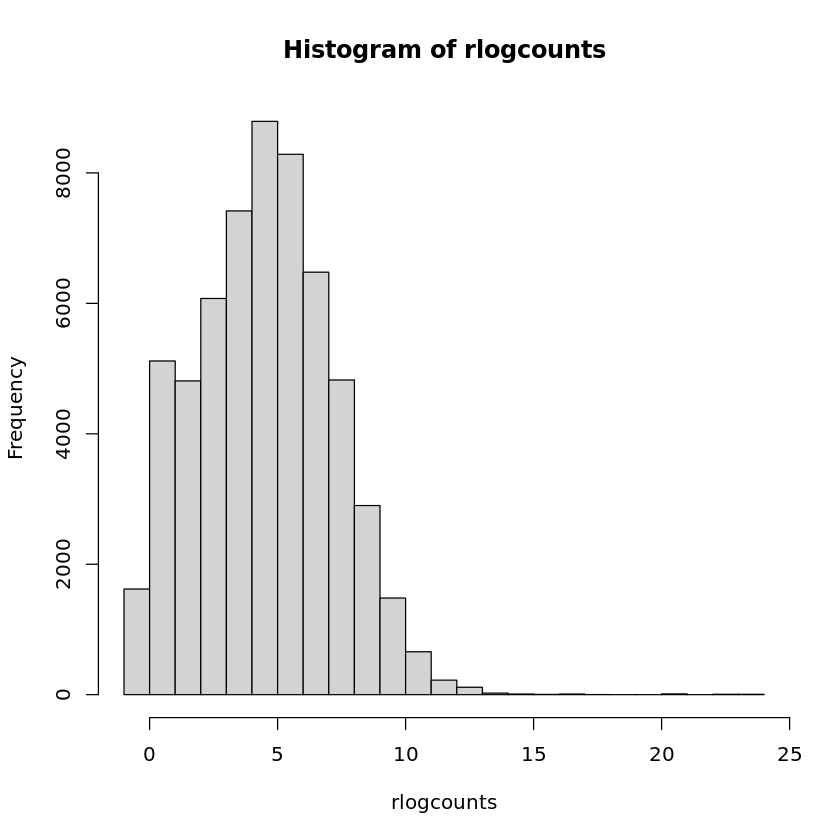

In [6]:
hist(rlogcounts)

Boxplots:

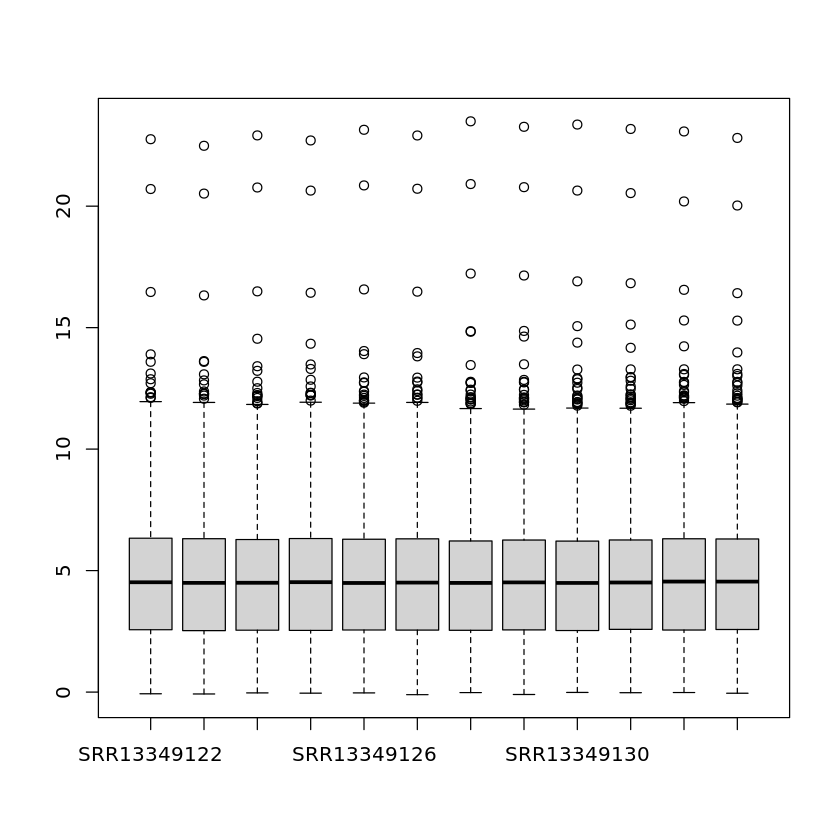

In [7]:
boxplot(rlogcounts)

Or pairwise comparison plots:

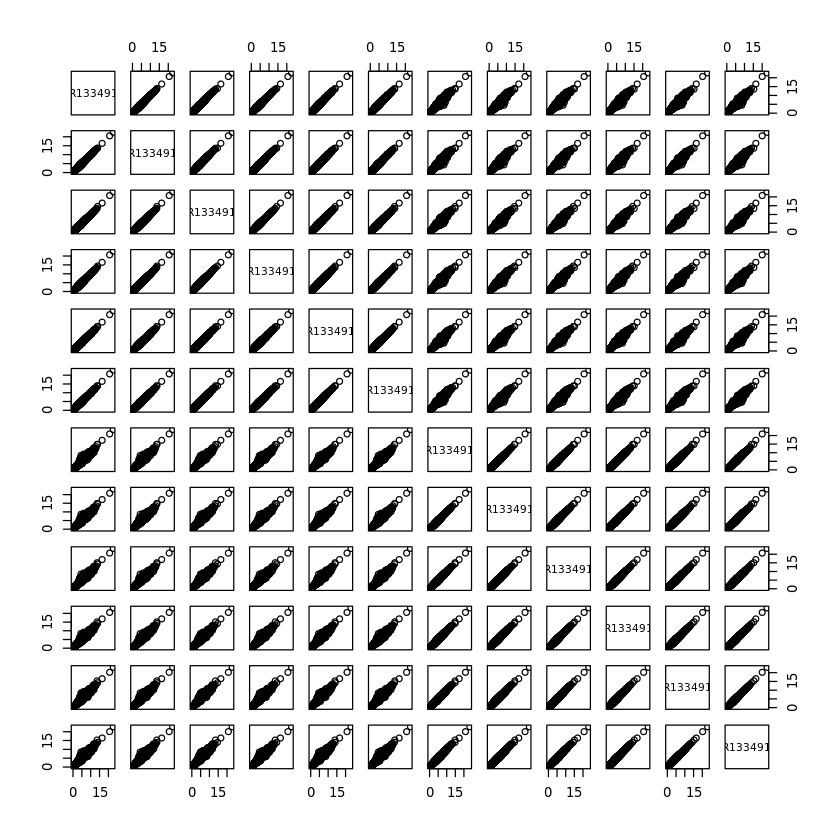

In [8]:
pairs(rlogcounts)

Beecause the data has been normalized the distirbution of the box plots are exactly the same.

### STEP 7: PCA Plot

One analysis is to plot and exmaine a PCA plot. PCA plots can be used to visualize variation within and between sample sets.

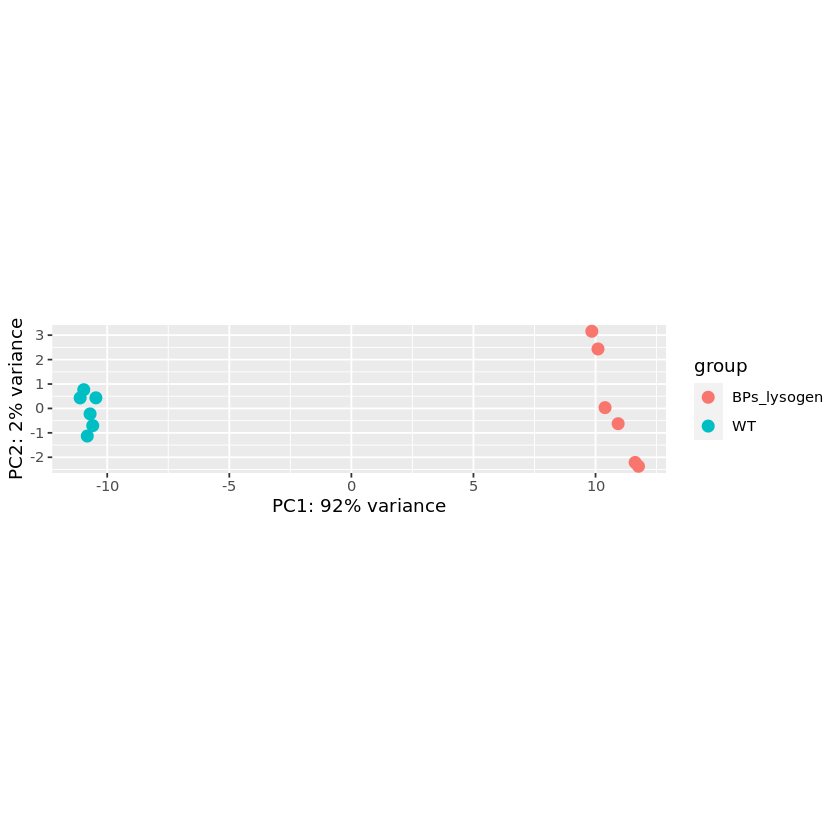

In [9]:
plotPCA(rld, intgroup=c("Treatment"))

Plots can be also saved as pdf or image files.

In [10]:
pdf("data/gene_counts/PCA_Plot.pdf")
plotPCA(rld, intgroup=c("Treatment"))
dev.off()

png 
  2

### STEP 8: Contrast Comparisons

Contrast comparisons between two treatment groups can be performed using the deseq2 tool to identify differentially up and down regulated genes.

Using R, these results can be summarized, reordered, and/or trimmed.

In [11]:
res_WT_BPs <- results(deseq2Data, contrast=c("Treatment","WT","BPs_lysogen"))
summary(res_WT_BPs)
print("Number of genes under a p value of 0.05")
sum(res_WT_BPs$pvalue < 0.05, na.rm=TRUE)
print("Number of genes under a p adjusted value of 0.05")
sum(res_WT_BPs$padj < 0.05, na.rm=TRUE)
head(res_WT_BPs)
#results can also be re-ordered using r
resOrdered_WT_BPs <- res_WT_BPs[order(res_WT_BPs$pvalue),]


out of 4906 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1093, 22%
LFC < 0 (down)     : 1001, 20%
outliers [1]       : 0, 0%
low counts [2]     : 476, 9.7%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "Number of genes under a p value of 0.05"


[1] 2110

[1] "Number of genes under a p adjusted value of 0.05"


[1] 1834

log2 fold change (MLE): Treatment WT vs BPs_lysogen 
Wald test p-value: Treatment WT vs BPs lysogen 
DataFrame with 6 rows and 6 columns
              baseMean log2FoldChange     lfcSE      stat      pvalue
             <numeric>      <numeric> <numeric> <numeric>   <numeric>
BB28_RS24845  34.95563        1.04087 0.1885797  5.519531 3.39906e-08
BB28_RS24840  94.89567        1.21139 0.1231134  9.839640 7.59821e-23
BB28_RS24300 298.25434        1.18267 0.0821263 14.400637 5.12687e-47
BB28_RS24270   1.31798        0.10969 0.8677096  0.126414 8.99404e-01
BB28_RS24265   5.86352        1.18597 0.4874097  2.433209 1.49657e-02
BB28_RS24255  12.72996       -1.20104 0.3052543 -3.934568 8.33466e-05
                    padj
               <numeric>
BB28_RS24845 2.37505e-07
BB28_RS24840 1.69146e-21
BB28_RS24300 3.72329e-45
BB28_RS24270          NA
BB28_RS24265 3.76052e-02
BB28_RS24255 3.64127e-04

### STEP 9: Annotating and Exporting Results

These differentially expressed genes can be annotated, if necessary, and exported.

In [12]:
#read the annotation file and store it into a variable.
annotation <- read.table("data/reference/GCF_001632805.1_ASM163280v1_feature_table.txt", header=TRUE,sep='\t', quote="\"",comment.char = "")
#put the previous deseq results into an easier to use data.frame format
results <- data.frame(res_WT_BPs)


#filter duplicate 'gene' rows
annotation <- annotation[annotation$X..feature!='gene',]
#

#join the deseq2 results with reference the annotation file
#in this case, our gene readcounts use the locus tag, so we will join by that.
#the locus tag is in our results rowname, and is in the 17th column of the annotation file

results.annot <- merge(results,annotation,by.x=0,by.y=17,all.x=TRUE)

#labeling the columns properly after the merge
colnames(results.annot)[1] <- 'locus_tag'

head(results.annot)

#writing out the file
write.table(results.annot,"data/gene_counts/WT_BPs_DESeq2_annot.txt",row.names=FALSE,sep="\t")

,locus_tag,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,X..feature,class,assembly,⋯,strand,product_accession,non.redundant_refseq,related_accession,name,symbol,GeneID,feature_interval_length,product_length,attributes
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<int>,<int>,<int>,<chr>
1,BB28_RS00005,233.66378,0.6862504,0.09102293,7.539313,4.724543e-14,5.797708e-13,CDS,with_protein,GCF_001632805.1,⋯,+,WP_030097698.1,WP_030097698.1,NA,chromosomal replication initiator protein DnaA,dnaA,31677580,1476,491,
2,BB28_RS00010,155.79412,0.2755786,0.09399720,2.931774,3.370317e-03,1.049227e-02,CDS,with_protein,GCF_001632805.1,⋯,+,WP_046251964.1,WP_046251964.1,NA,DNA polymerase III subunit beta,dnaN,31677581,1200,399,
3,BB28_RS00015,170.15979,0.5914482,0.09521071,6.211992,5.231693e-10,4.457000e-09,CDS,with_protein,GCF_001632805.1,⋯,+,WP_046251966.1,WP_046251966.1,NA,decarboxylating 6-phosphogluconate dehydrogenase,gnd,31677582,894,297,
4,BB28_RS00020,50.14872,0.9129939,0.15575583,5.861700,4.581528e-09,3.505383e-08,CDS,with_protein,GCF_001632805.1,⋯,+,WP_046251967.1,WP_046251967.1,NA,DNA replication/repair protein RecF,recF,31677583,1149,382,
5,BB28_RS00025,56.23893,0.5222818,0.15052082,3.469831,5.207863e-04,1.971866e-03,CDS,with_protein,GCF_001632805.1,⋯,+,WP_046251969.1,WP_046251969.1,NA,DUF721 family protein,,31677584,552,183,
6,BB28_RS00030,1652.41103,-0.0776889,0.05201116,-1.493697,1.352549e-01,2.346042e-01,CDS,with_protein,GCF_001632805.1,⋯,+,WP_046251970.1,WP_046251970.1,NA,DNA topoisomerase (ATP-hydrolyzing) subunit B,gyrB,31677585,2028,675,


### STEP 10: More Plots and Clustering Data

The results of differential gene expression analysis can be used to make various plots, including ma and heatplots. Heatplots can also be used to further cluster the data with k-mean derived dendrograms.


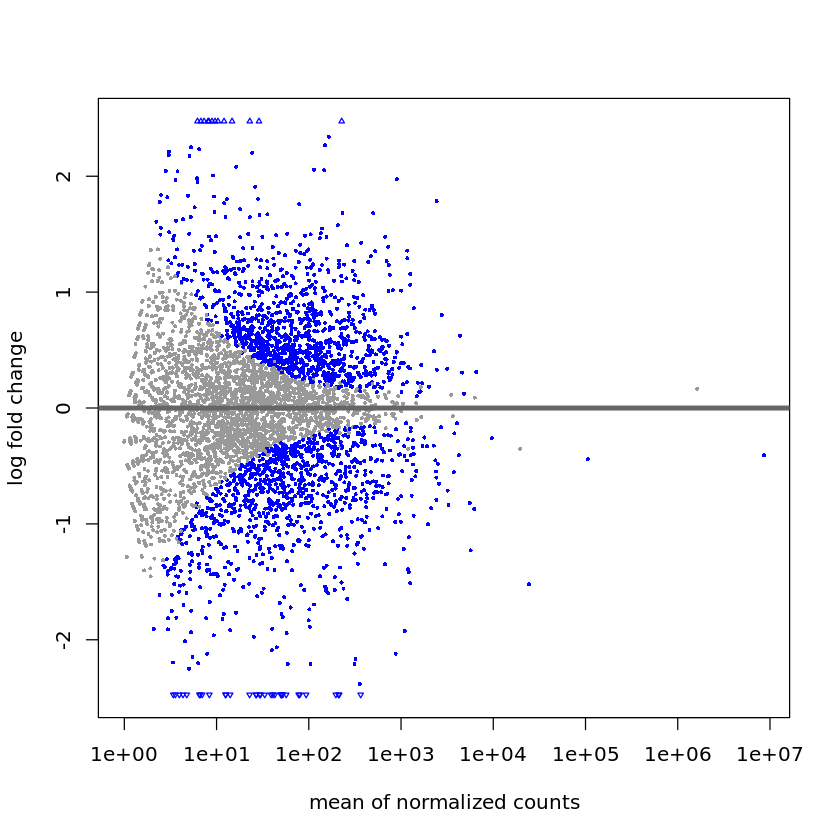

Warning message:
“Removed 476 rows containing missing values (geom_point).”


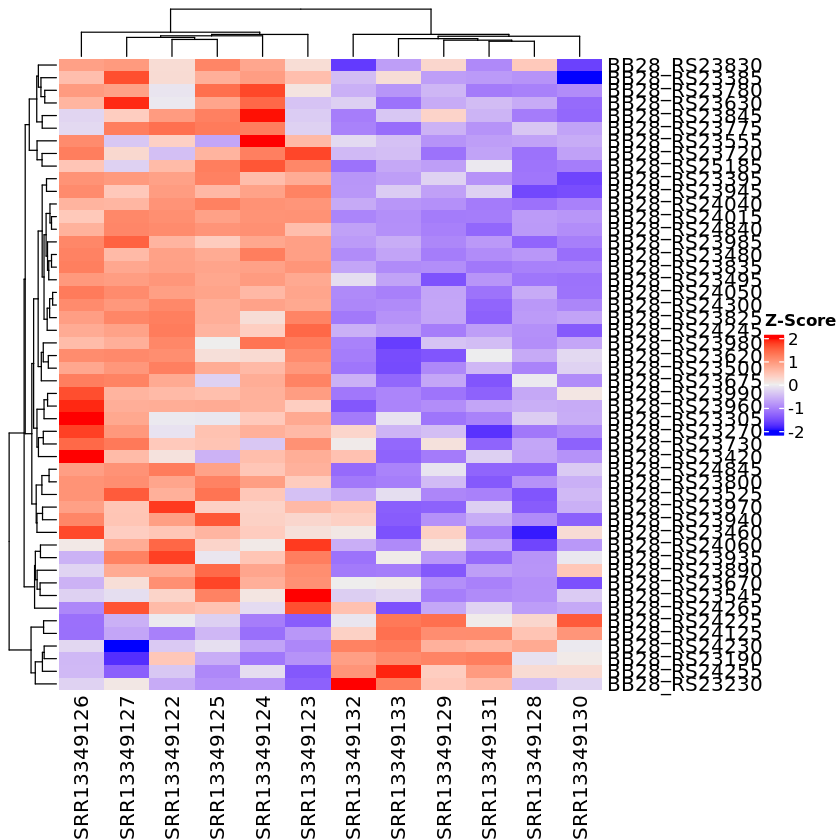

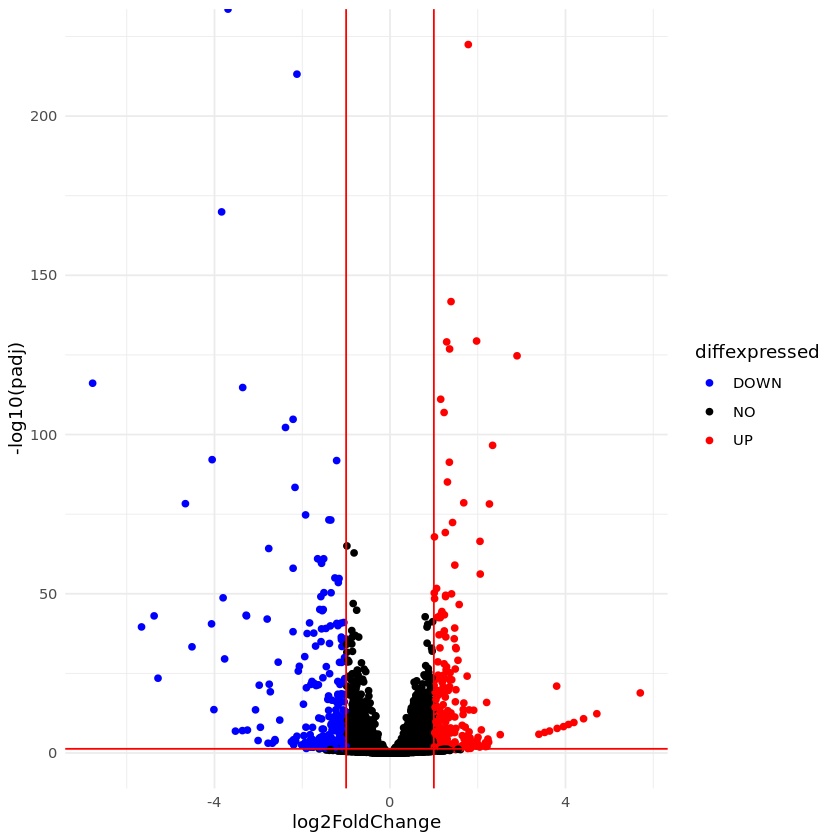

In [70]:
#ma plot; here the blue points indicate genes with an fd less than 0.05
plotMA(res_WT_BPs)


#heatmaps can used to look at clustering and expression of various gene lists.

filtered_res <- results.annot %>% filter(padj < 0.05)
filtered_res_counts <- subset(rlogcounts, rownames(rlogcounts) %in% filtered_res[,1])

#scaling for z score
filtered_res_counts = t(scale(t(filtered_res_counts)))

Heatmap(filtered_res_counts[1:50,], name = "Z-Score")

#add volcano plot

results_volc_df <- results.annot
results_volc_df$diffexpressed <- rep("NO",nrow(results_volc_df))

results_volc_df$diffexpressed[results_volc_df$padj < 0.05 & results_volc_df$log2FoldChange > 1] <- "UP"
results_volc_df$diffexpressed[results_volc_df$padj < 0.05 & results_volc_df$log2FoldChange < -1] <- "DOWN"


ggplot(data=results_volc_df, aes(x=log2FoldChange, y=-log10(padj), col=diffexpressed)) +
        geom_point() + 
        theme_minimal() +
        scale_color_manual(values=c("blue", "black", "red")) +
        geom_vline(xintercept=c(-1, 1), col="red") +
        geom_hline(yintercept=-log10(0.05), col="red")
